In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns                     
import sklearn

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay, classification_report, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as cb
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_classification
import optuna

from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import (ROCAUC)
from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')


/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Import Processed train, test, and validation sets

In [7]:
X_train_res = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/Customer Churn Final Project/customer_churn_2024/data/X_train_res.csv')
X_test = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/Customer Churn Final Project/customer_churn_2024/data/X_test.csv')
X_val = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/Customer Churn Final Project/customer_churn_2024/data/X_val.csv')
y_train_res = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/Customer Churn Final Project/customer_churn_2024/data/y_train_res.csv')
y_test = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/Customer Churn Final Project/customer_churn_2024/data/y_test.csv')
y_val = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/Customer Churn Final Project/customer_churn_2024/data/y_val.csv')

## SVM

In [53]:
# Initialize SVM classifier
svm = SVC()

# Fit the model to the training data
svm.fit(X_train_res, y_train_res)


SVC()

In [54]:
# Create reusable evaluation function
def evaluate_model(model, X_data, y_data, dataset_name):
    # Make predictions
    y_pred = model.predict(X_data)
    
    # Print evaluation metrics
    print(f"\n{dataset_name} Set Evaluation:")
    print(classification_report(y_data, y_pred))
    print(f"{dataset_name} Set Accuracy:", accuracy_score(y_data, y_pred))
    print(f"{dataset_name} Set Recall:", recall_score(y_data, y_pred))
    
    # Calculate the F-beta score
    beta = 2
    f_beta = fbeta_score(y_data, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) on {dataset_name} set: {f_beta}")


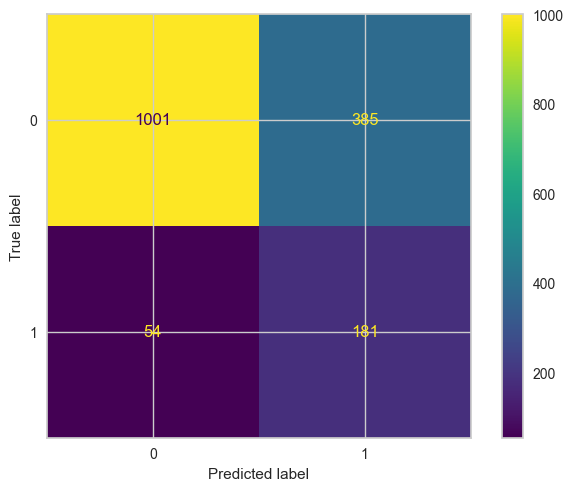

In [56]:
# Confusion matrix

# get y predictions
y_val_pred = svm.predict(X_val)

conf_matrix_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)


## Hyperparameter Tuning with GridSearchCV

In [12]:
param_grid = {'C': [0.1,1, 10, 15,20, 50, 100], #regularization parameter. Small C means more regularization (more generalized results)
              'gamma': [0.001, 0.00001, 0.0000001], #small gamma will create a smoother decision boundary, while a large gamma will make the decision boundary more irregular
              'kernel': ['rbf','sigmoid']} #different kernel types

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=True, n_jobs=-1)

grid.fit(X_val,y_val)


Fitting 5 folds for each of 42 candidates, totalling 210 fits


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 15, 20, 50, 100],
                         'gamma': [0.001, 1e-05, 1e-07],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=True)

In [13]:
print(grid.best_params_)

{'C': 15, 'gamma': 1e-07, 'kernel': 'rbf'}


## Fit SVM with best parameters

In [57]:
best_params = grid.best_params_

best_svm = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
best_svm.fit(X_train_res, y_train_res)

evaluate_model(best_svm, X_val, y_val, "Validation")



Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1386
           1       0.52      0.83      0.64       235

    accuracy                           0.87      1621
   macro avg       0.75      0.85      0.78      1621
weighted avg       0.90      0.87      0.88      1621

Validation Set Accuracy: 0.865515114127082
Validation Set Recall: 0.8297872340425532
F-beta score (beta=2) on Validation set: 0.7425742574257426


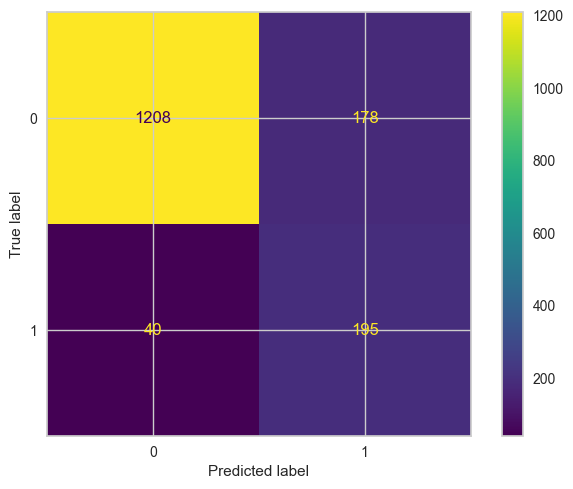

In [77]:
# Best SVM Confusion matrix

# get y predictions
y_val_pred = best_svm.predict(X_val)

conf_matrix_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)


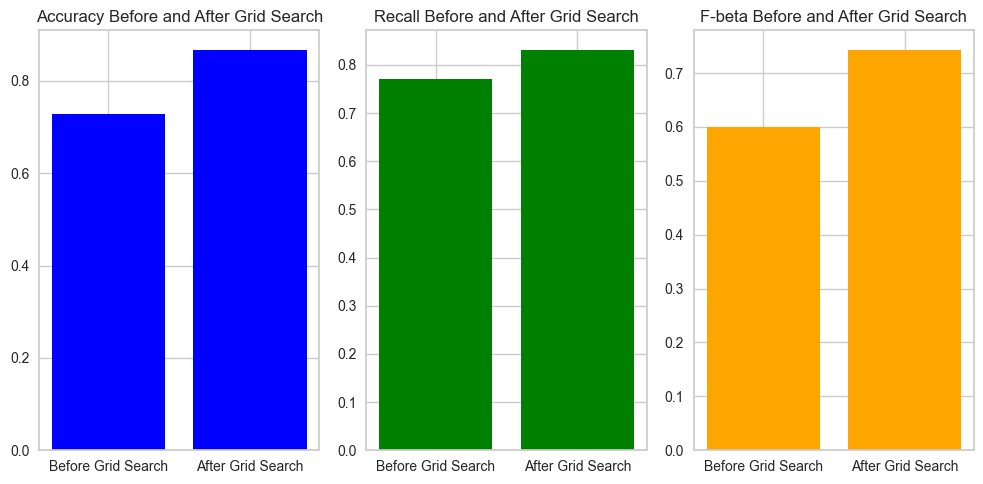

In [62]:
# Plot improvement before and after grid search
labels = ['Before Grid Search', 'After Grid Search']
accuracy = [0.729, 0.866]
recall = [0.770, 0.830]
fbeta = [0.60,0.742]

# Plot accuracy and recall side by side
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot accuracy
axs[0].bar(labels, accuracy, color='blue')
axs[0].set_title('Accuracy Before and After Grid Search')

# Plot recall
axs[1].bar(labels, recall, color='green')
axs[1].set_title('Recall Before and After Grid Search')

# Plot f beta
axis = axs[2].bar(labels, fbeta, color='orange')
axs[2].set_title('F-beta Before and After Grid Search')

plt.tight_layout()
plt.show()

## Validation

## PR Curve

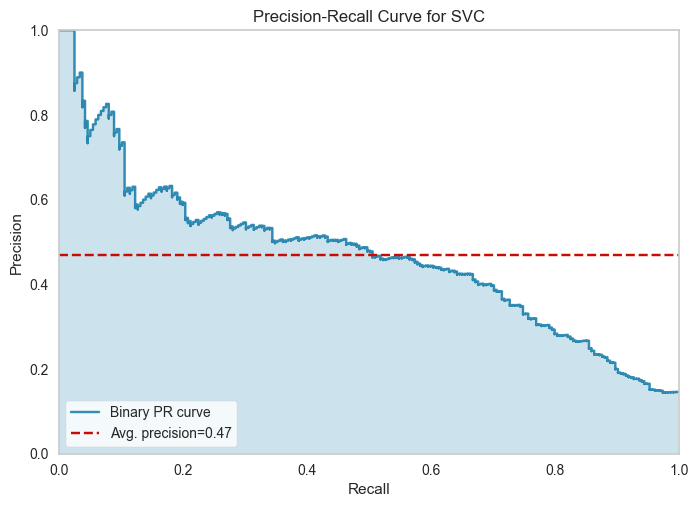

<Axes: title={'center': 'Precision-Recall Curve for SVC'}, xlabel='Recall', ylabel='Precision'>

In [63]:
viz = PrecisionRecallCurve(svm, is_fitted=True)
viz.fit(X_train_res, y_train_res)
viz.score(X_val, y_val)
viz.show()

## ROC-AUC

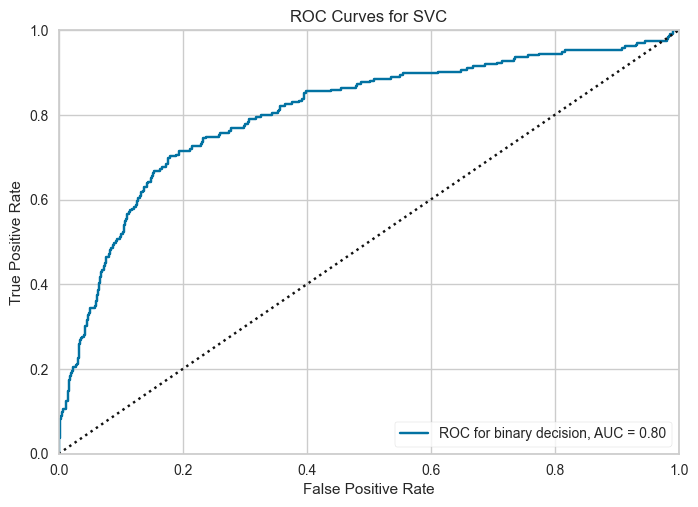

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [64]:
classes = ["0", "1"]
visualizer = ROCAUC(svm, classes=classes, is_fitted=True, binary = True)

visualizer.fit(X_train_res, y_train_res)       
visualizer.score(X_val, y_val)      
visualizer.show()

ROC is 0.8, this shows that the model performs well at distinguishing posistive and negative values. 

## SVM Predictions on Test Set

In [65]:
y_test_pred = best_svm.predict(X_test)

evaluate_model(best_svm, X_test, y_test, "Test")


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1699
           1       0.54      0.81      0.64       327

    accuracy                           0.86      2026
   macro avg       0.75      0.84      0.78      2026
weighted avg       0.89      0.86      0.87      2026

Test Set Accuracy: 0.8558736426456071
Test Set Recall: 0.8073394495412844
F-beta score (beta=2) on Test set: 0.7329261521377013


## Stacked

### Default meta learner

In [78]:
models = [
    ('ann', MLPClassifier(hidden_layer_sizes=(11,), max_iter=1000, random_state=0)),
    ('svm', best_svm), #{'C': 15, 'gamma': 1e-07, 'kernel': 'rbf'}
    ('random_forest', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300)),
    ('decision_tree', DecisionTreeClassifier(max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2)),
    ('catboost', cb.CatBoostClassifier(iterations=649, learning_rate=0.2568567081947971, depth=4, l2_leaf_reg=3, border_count=180, verbose=0)), 
    ('knn', KNeighborsClassifier(n_neighbors=2))
]

stacking = StackingClassifier(estimators=models, cv=5)

In [79]:
# Run the model
stacking.fit(X_train_res, y_train_res)

evaluate_model(stacking, X_val, y_val, "Validation")


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1386
           1       0.91      0.91      0.91       235

    accuracy                           0.97      1621
   macro avg       0.95      0.95      0.95      1621
weighted avg       0.97      0.97      0.97      1621

Validation Set Accuracy: 0.974090067859346
Validation Set Recall: 0.9148936170212766
F-beta score (beta=2) on Validation set: 0.913338997451147


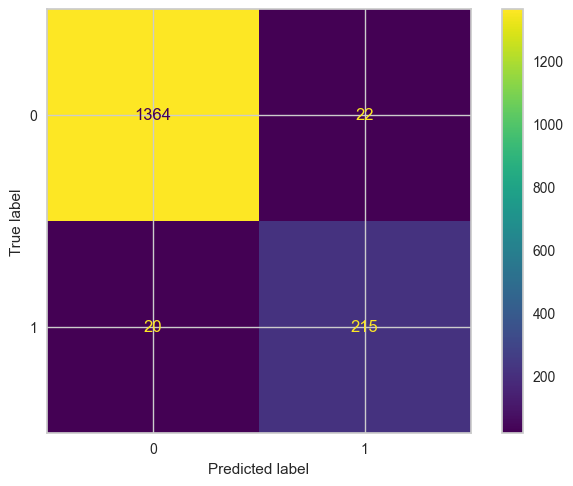

In [80]:
# Confusion matrix stacking
y_val_pred = stacking.predict(X_val)

conf_matrix_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

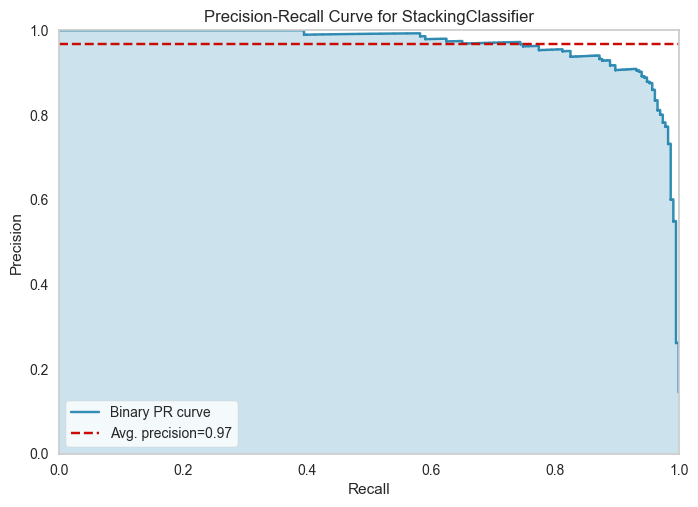

<Axes: title={'center': 'Precision-Recall Curve for StackingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [83]:
# Precision recall curve
viz = PrecisionRecallCurve(stacking, is_fitted=True)
viz.fit(X_train_res, y_train_res)
viz.score(X_val, y_val)
viz.show()

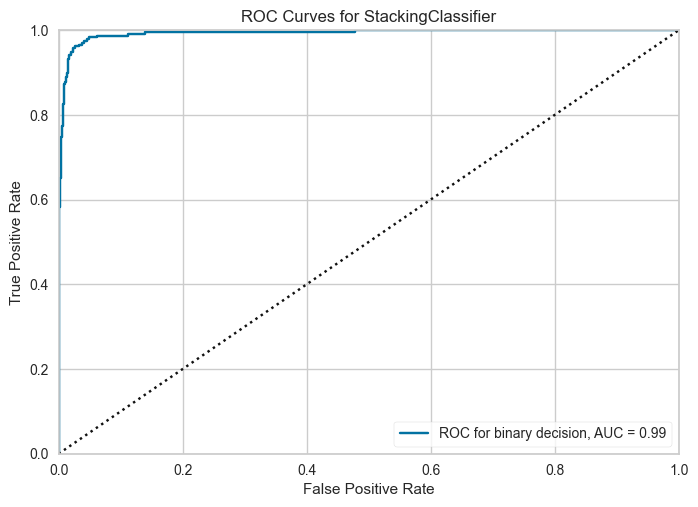

<Axes: title={'center': 'ROC Curves for StackingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [84]:
# ROC AUC curve
classes = ["0", "1"]
visualizer = ROCAUC(stacking, classes=classes, is_fitted=True, binary = True)

visualizer.fit(X_train_res, y_train_res)       
visualizer.score(X_val, y_val)      
visualizer.show()

AUC of 0.99 means tha the model almost perfectly differentiates the two binary classes

## Stacking Model Contribution

ann: 0.0843213845707924
svm: 0.018076158842538267
random_forest: 0.4624474415148457
decision_tree: 0.008841815688371491
catboost: 0.2316191527364924
knn: 0.19469404664695977


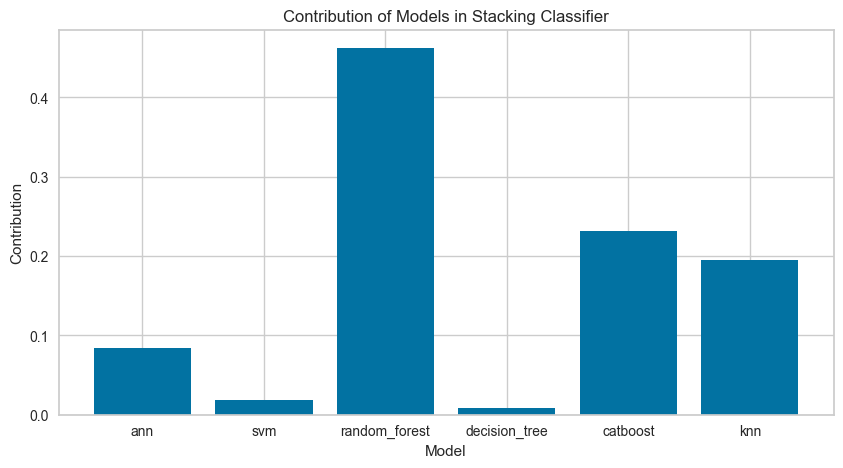

In [85]:
final_estimator_coefs = stacking.final_estimator_.coef_

# Normalizing coefficients to sum up to 1
normalized_coefs = np.abs(final_estimator_coefs) / np.sum(np.abs(final_estimator_coefs))

# Printing the normalized coefficients
for model, coef in zip(models, normalized_coefs[0]):
    print(f"{model[0]}: {coef}")
    
# plot contribution of models
plt.figure(figsize=(10, 5))
plt.bar([model[0] for model in models], normalized_coefs[0])
plt.title('Contribution of Models in Stacking Classifier')
plt.xlabel('Model')
plt.ylabel('Contribution')
plt.show()


In [86]:
# Evaluate on test set
evaluate_model(stacking, X_test, y_test, "Test")



Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.88      0.91      0.89       327

    accuracy                           0.97      2026
   macro avg       0.93      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Test Set Accuracy: 0.9654491609081934
Test Set Recall: 0.9051987767584098
F-beta score (beta=2) on Test set: 0.9007912355447353


## Learning curve

In [87]:
# Make reusable function
def plot_learning_curve(estimator, title, X, y, ylim=None, cv = None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'fbeta_score'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F Beta Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas re

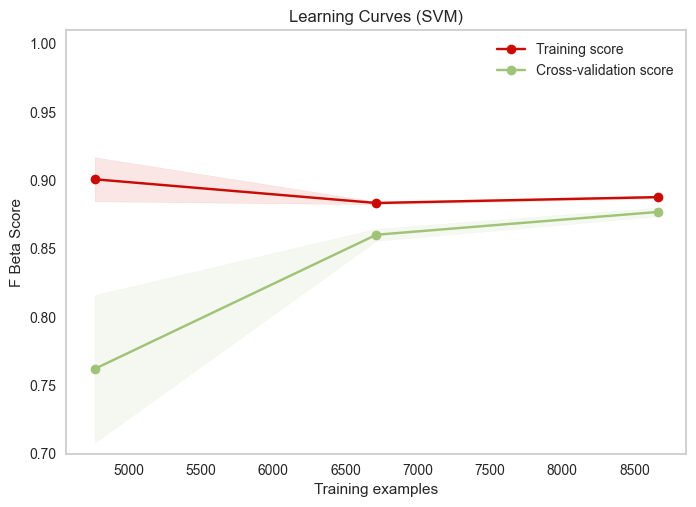

In [88]:
# SVM learning curve
title = "Learning Curves (SVM)"
cv = 5 
plot_learning_curve(best_svm, title, X_train_res, y_train_res, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

Cross validation F Beta score increases as the training set increase, while the training F Beta score descreases as sample size increase at first, then training score increases moderately as training size increases. This shows that the model is not overfitting to new data. 

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was pas

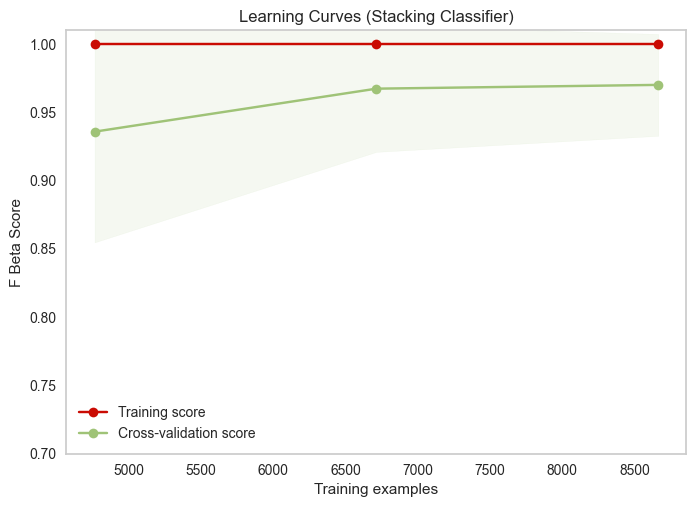

In [89]:
# Stacking classifier learning curve
title = "Learning Curves (Stacking Classifier)"
cv = 5 
plot_learning_curve(stacking, title, X_train_res, y_train_res, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

Training score is almost perfect since the start. The model is already performing well. No matter if we increase the training example, the F Beta score will be high.